<a href="https://colab.research.google.com/github/HannaKi/DL_HLT_2020_groupwork/blob/master/DLHLT_2020_Group2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning in Human Language Technologies 2020
# Text classification project 12.5.2020

#### Group 2: Hanna Kitti, Dang Trinh Ha, Timo Jokela

Contributions:
This project was a joint effort by all the participants, all three of us dedicating a considerable amount of time for the various phases of the project. The amount of work done can be roughly estimated as: Kitti 35 %, Ha 30 %, Jokela 35 %.

Over the course of solving the milestones we changed ideas and discussed different ways to solve separate sub tasks, problems and frustration that occasionally rose. This mutual support can not be evidently seen from the code but it definitely guided us to the final solutions and results we gained.

What follows is a **very approximate** description of the contributions.  
Lead: the person primarily responsible for the implementation  
Support: Mentoring, problem solving, testing with alternative parameters  

**Milestone 1:**  
Jokela: Lead  
Kitti: Support  
Ha: Support  

**Milestone 2:**  
Kitti: Lead (Keras BERT), support  
Jokela: Lead (PyTorch BERT), support  
Ha: Support  

**Milestone 3:**  
Kitti: Lead  
Jokela: Support  
Ha: Support  

### System dependent configuration

**NOTE: This notebook is composed of pieces obtained during several kernel instances.** Different platforms (both desktop and Colab) encountered memory allocation issues when attempting to execute the notebook during a single kernel instance, mainly due to BERT models being very resource hungry.

In [1]:
import sys
from pathlib import Path

# Are we running in a Colab environment?
IN_COLAB = 'google.colab' in sys.modules

# Do we want to omit some tedious tasks? (Embedding generation, GridSearchCV)
USE_PRECOMPUTED_FILES = True

if IN_COLAB:
    !pip install transformers
    !pip3 install keras-bert
    !pip install scikit-multilearn
    
    # Download development data
    !wget http://dl.turkunlp.org/TKO_8965-projects/classification/fincore-dev.tsv
    # Download test data
    !wget http://dl.turkunlp.org/TKO_8965-projects/classification/fincore-test.tsv
    # Download train data
    !wget http://dl.turkunlp.org/TKO_8965-projects/classification/fincore-train.tsv
  
    # Download pretrained TurkuNLP FinBERT from: https://github.com/TurkuNLP/FinBERT
    !wget -nc http://dl.turkunlp.org/finbert/bert-base-finnish-cased-v1.zip
    # Give -n argument so that existing files aren't overwritten 
    !unzip -n bert-base-finnish-cased-v1.zip


    if USE_PRECOMPUTED_FILES:
        # Download pre-computed FastText embedding matrix 
        !wget https://seafile.utu.fi/f/75d03975f06d4784b23e/?dl=1 -O rnn_embedding_matrix.p
        # Download pre-computed BOW GSCV results
        !wget https://seafile.utu.fi/f/975f0bf59a2f48bab603/?dl=1 -O bow_grid_results.p
    
    bert_vocab_path = 'bert-base-finnish-cased-v1/vocab.txt'
    bert_config_path = 'bert-base-finnish-cased-v1/bert_config.json'
    bert_checkpoint_path = 'bert-base-finnish-cased-v1/bert_model.ckpt'
    bow_model_filepath = 'bow_model.h5'
    rnn_model_filepath = 'rnn_model.h5'
    
    embedding_matrix_file = Path('rnn_embedding_matrix.p')
    bow_grid_file = Path('bow_grid_results.p')
    
    train_file = 'fincore-train.tsv'
    dev_file = 'fincore-dev.tsv'
    test_file = 'fincore-test.tsv'
    
    # Milestone 2: training batch size
    MS2_BATCH_SIZE = 16
    
else:
    bow_model_filepath = '/tmp/bow_model.h5'
    rnn_model_filepath = '/tmp/rnn_model.h5'
    
    bert_base_dir = Path.home() / 'Documents/BERT/bert-base-finnish-cased-v1'
    bert_vocab_path = str(bert_base_dir / 'vocab.txt')
    bert_config_path = str(bert_base_dir / 'bert_config.json')
    bert_checkpoint_path = str(bert_base_dir / 'bert_model.ckpt')
    
    embedding_matrix_file = Path.home() / 'Documents/DLHLT/rnn_embedding_matrix.p'
    bow_grid_file = Path.home() / 'Documents/DLHLT/bow_grid_results.p'
    train_file = Path.home() / 'Documents/DLHLT/fincore-train.tsv'
    dev_file = Path.home() / 'Documents/DLHLT/fincore-dev.tsv'
    test_file = Path.home() / 'Documents/DLHLT/fincore-test.tsv'
    
    # Milestone 2: training batch size
    MS2_BATCH_SIZE = 8
    
keras_bert_results_file = Path.home() / 'Documents/DLHLT/keras_bert_results.p'
pytorch_bert_results_file = Path.home() / 'Documents/DLHLT/pytorch_bert_results.p'

## Preparations

### Imports

In [2]:
import collections
import io
import json
import numpy as np
import os
import pandas as pd
import pprint
import pickle
import seaborn as sns
import torch
import transformers

from matplotlib import pyplot as plt
from numba import cuda
from pytorch_pretrained_bert import (
    BertTokenizer as PTBertTokenizer,  # prefix all with PT for consistency
    BertConfig as PTBertConfig,
)
from pytorch_pretrained_bert import (
    BertAdam as PTBertAdam, 
    BertForSequenceClassification as PTBertForSequenceClassification
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    multilabel_confusion_matrix
)
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import (
    LabelEncoder, MultiLabelBinarizer, StandardScaler
)
from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Embedding, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from torch.utils.data import TensorDataset, DataLoader

%matplotlib inline
pp = pprint.PrettyPrinter(indent=4)

### Dataset

Data split

- Training set: used for training the models
- Validation (or model assessment) set: when comparing
different models trained on training set, select one with lowest
error on validation set
- Test set: test the final hypothesis on test set to get unbiased
error estimate for it

After error estimation the final model is often trained on
combined training, validation and test set, using best
hyperparameters found during model selection
- Complication: randomized optimization approaches where
different runs with same hyperparameters can lead to very
different quality solutions (e.g. neural network)

In [3]:
orig_columns = ['reg', 'text']

# load the data
df_train = pd.read_csv(train_file, sep='\t', names=orig_columns)
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

df_dev_full = pd.read_csv(dev_file, sep='\t', names=orig_columns)
df_dev_full = (df_dev_full.sample(frac=1, random_state=42)
                          .reset_index(drop=True))

df_test_full = pd.read_csv(test_file, sep='\t', names=orig_columns)
df_test_full = (df_test_full.sample(frac=1, random_state=42)
                            .reset_index(drop=True))

The following classes of the test and development sets are not in the training set:

In [4]:
print("Dev/test classes not in the training set:\n")
print(df_test_full[~df_test_full.reg.isin(df_train.reg.unique())].reg.unique())
print(df_dev_full[~df_dev_full.reg.isin(df_train.reg.unique())].reg.unique())

Dev/test classes not in the training set:

['FC NA DP IN ' 'FC NA DT IN ' 'SL LY ' 'HI  IP IG ' 'IB IN IN  '
 'RE HI PB NA ' 'IT SP DT IN ' 'RV OP PB NA ' 'IP IG NE NA '
 'NE NA DT IN ' 'CB NA EB IG ' 'OA NA FC NA ' 'DS IG AV OP ']
['ID  PB NA ' 'DS IG MT OS ' 'DF ID NE NA ' 'OP  DP IN ' 'DF ID PB NA '
 'TB NA CB NA ']


Since we can not train the model to predict labels it has not seen during training phase, we will keep only rows in dev and test data which have the labels that appear also in training data:

In [5]:
df_test = df_test_full[
    df_test_full.reg.isin(df_train.reg.unique())].reset_index(drop=True)
df_dev = df_dev_full[
    df_dev_full.reg.isin(df_train.reg.unique())].reset_index(drop=True)

Texts for all the datasets:

In [6]:
txt_train = [x for x in df_train.text]
txt_dev = [x for x in df_dev.text]
txt_test = [x for x in df_test.text]

Encoded labels (registers):

In [7]:
# labels as numbers
label_encoder = LabelEncoder()
train_classes = label_encoder.fit_transform(df_train.reg)
dev_classes = label_encoder.transform(df_dev.reg)
test_classes = label_encoder.transform(df_test.reg)
num_classes = len(label_encoder.classes_)

#### Some initial thoughts

We draw a chart for visualizing the distribution of different kinds of classes.

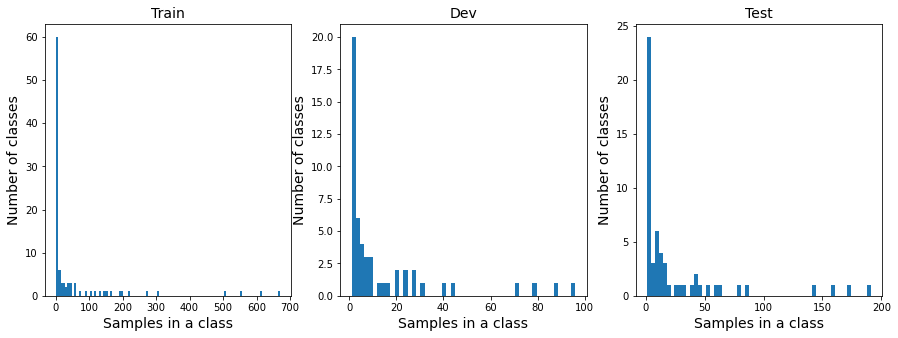

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, (df, name) in enumerate(zip([df_train, df_dev, df_test],
                                   ['Train', 'Dev', 'Test'])):
    ax[i].hist(df.reg.value_counts().values, bins=len(df.reg.unique()))
    ax[i].set_title(name, fontsize=14)
    ax[i].set_xlabel("Samples in a class", fontsize=14)
    ax[i].set_ylabel("Number of classes", fontsize=14)
plt.show()

We immediately observe that the number of classes with just one sample is very high, whereas there are lot less classes that have several representatives. That is, the distribution of labels is highly skewed in all the data sets. This could be fixed with data augmentation but since we have no experience, we settle for the data provided. Also further manual annotation to gain more data would probably improve model performance in all the upcoming classifiers.

Especially predicting the labels which have only a few instances in the data will be a challenging task for the classifiers since they might not be able to truly learn the characteristics of the label by one or two instances.

Small classes (labels) also hinder using powerful hyperparameter optimizers, such as GridSearch, in optimal way: Stratification for K-folds in inner and outer loops is impossible because of the scarcity of the instances in the smallest classes.

## Milestone 1

For the first two models we construct vocabularies of alternative sizes:

In [ ]:
print("Generating vocabularies...")
max_features_options = [1000, 10000, 20000, 30000, 40000, 50000]
ms1_vocabs = {}
for mf in max_features_options:
    # a vectorizer and the feature matrices for this particular max_features
    # NOTE: outside of this notebook other params were tested; see baseline
    vectorizer = CountVectorizer(max_features=mf,
                                 binary=False,
                                 ngram_range=(1, 1))
    ms1_vocabs[mf] = {
        'vectorizer': vectorizer,
        'train_fm': vectorizer.fit_transform(txt_train),
        'dev_fm': vectorizer.transform(txt_dev),
        'test_fm':  vectorizer.transform(txt_test)
    }
print("Done.")

### 1.0: Baseline (Naive Bayes)

Naive Bayes classifier to be used as a baseline. It is trained on the training data for each separate dataset (different _max_features_ params for the CountVectorizer). Additionally accuracy on the permutated test sets are computed for the purpose of ensuring that performance with actual data differs from performance with junk data.

In [ ]:
def mnb_compute(X, y, mnb):
    predictions = mnb.predict(X)
    return (np.sum(predictions == y) / len(y), predictions)

bayes_results = {}
print("Computing stats for the MNB models...")
for max_feats, vocab in ms1_vocabs.items():
    # train using the training set
    mnb = MultinomialNB()
    mnb.fit(vocab['train_fm'], df_train.reg)

    # the accuracy of the trained model on all the sets
    train_accuracy, _ = mnb_compute(vocab['train_fm'], df_train.reg, mnb)
    dev_accuracy, _ = mnb_compute(vocab['dev_fm'], df_dev.reg, mnb)
    test_accuracy, test_preds = mnb_compute(vocab['test_fm'], df_test.reg, mnb)
    
    # accuracy on permutated test set
    permutated = np.random.permutation(df_test.reg)
    perm_accuracy, _ = mnb_compute(vocab['test_fm'], permutated, mnb)
    
    bayes_results[max_feats] = {
        'train_accuracy': train_accuracy,
        'dev_accuracy': dev_accuracy,
        'test_accuracy': test_accuracy,
        'test_predictions': test_preds,
        'perm_accuracy': perm_accuracy,
    }
print("Done.")

In [ ]:
for mf, stats in bayes_results.items():
    print(f"\nMax features: {mf}\nACCURACY: "
          f"Train {stats['train_accuracy']:.2f}  "
          f"Dev {stats['dev_accuracy']:.2f}  "
          f"Test {stats['test_accuracy']:.2f}  "
          f"Permutated {stats['perm_accuracy']:.2f}  ")


**NOTE**: Outside of this notebook other params (*binary, ngram*) for the CountVectorizer were also tested. Neither here nor with the BOW model had they any practical effect whatsoever. Also, the value of the *max_features* parameter seems to be the most effective approximately in the range of 20 - 40 k, after which the accuracy begins to slowly degrade (possibly due to more features contributing only noise). 

**Having several different models for different parameter sets proved to be very demanding RAM-wise (particularly for BOW)**, and therefore, to keep the hardware requirements in check, we reduced the number of different *max_feature*s values to three:

In [ ]:
%%capture
# limit the number of different max_features params
max_features_options = [1000, 10000, 30000]
ms1_vocabs.pop(20000)
ms1_vocabs.pop(40000)
ms1_vocabs.pop(50000)

### 1.1: BOW

We tried several optimizers, of which SGD and Adam seemed to be the most effective. Therefore we decided to cover only them in this notebook:

In [ ]:
keras_optimizers = {
    'SGD': optimizers.SGD,
    'Adam': optimizers.Adam,
}

Next we define the function responsible for building the bow model.


**NOTE**: Outside of this notebook several alternative model constructions were tested. These included other forms of regularization (e.g. dropout), different setups for hidden layer(s) and using pre-computed weights due to the data being imbalanced. None of these had any practical effect.

In [ ]:
def build_bow_model(
        feature_matrix, activation=None, optimizer=None, learning_rate=None
    ):
    """ Builds the BOW model according to the parameters """
    doc_count, feature_count = feature_matrix.shape
    inp = Input(shape=(feature_count,))
    hidden = Dense(250, activation=activation)(inp)
    output = Dense(num_classes, activation="softmax")(hidden)
    model = Model(inputs=[inp], outputs=[output])
    optimizer = optimizer(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

We also performed GridSearchCV for the following parameter combinations:
- max_features: 1000, 10000, 30000
- optimizers: SGD, Adam
- activation: tanh, ReLU
- learning rate:  0.00098, 0.00310, 0.00984, 0.03125, 0.09921, 0.31498, 1.0


**NOTE**: This is an extremely taxing process both time- and resource-wise (allocating in total 20 GB of RAM + some swap on the side). Therefore we do not repeat the full computation here, but only list some of the best results, with which we will proceed. Change *DO_BOW_GSCV* to **True** to run the full operation.

Given the availability of sufficient resources, it would also be an option to optimize several other factors (not necessarily using GridSearchCV if not applicable but by other means) such as hidden layer composition or dropout rate (if used). However, due to limited time and hardware we have to settle for the options mentioned above.

In [ ]:
# set to True to perform GridSearchCV again
DO_BOW_GSCV = False

In [ ]:
if DO_BOW_GSCV or not bow_grid_file.is_file():
    mc = ModelCheckpoint(filepath=bow_model_filepath,
                         monitor='accuracy',
                         verbose=0,
                         save_best_only=True,
                         mode='auto')

    es = EarlyStopping(monitor='accuracy',
                       patience=20,
                       verbose=0,
                       restore_best_weights=True)

    bow_grid_params = {
        'activation': ['tanh', 'relu'],
        'optimizer': list(keras_optimizers.values()), 
        'learning_rate': np.logspace(-10, 0, num = 7, base = 2).tolist()
    }
    grid_results = {}
    for mf in max_features_options:
        print(f"BOW: GridSearchCV for param max_features={mf}")
        feature_matrix = ms1_vocabs[mf]['train_fm']

        def f(activation=None, optimizer=None, learning_rate=None):
            return build_bow_model(
                feature_matrix,
                activation=activation, 
                optimizer=optimizer,
                learning_rate=learning_rate
            )

        grid = GridSearchCV(
            estimator=KerasClassifier(
                build_fn=f, epochs=40, batch_size=32, verbose=0),
            param_grid=bow_grid_params,
            n_jobs=1,
            cv=3,
            verbose=0,
        )
        grid_results[mf] = grid.fit(
            feature_matrix.toarray(), train_classes, callbacks=[es, mc])
    print("Done.")

    bow_grid_results = {}
    for mf in max_features_options:
        res = grid_results[mf]
        bow_grid_results[mf] = {
            'params': res.cv_results_['params'],
            'rank_test_score': res.cv_results_['rank_test_score'],
            'mean_test_score': res.cv_results_['mean_test_score']
        }
    pickle.dump(bow_grid_results, open(bow_grid_file, 'wb'))
else:
    bow_grid_results = pickle.load(open(bow_grid_file, 'rb'))
    print("BOW: Loaded GridSearchCV results from a file.")

The following parameter sets ranked the best:

In [ ]:
bow_params = {}  # For storing the best models for final comparison
for mf in max_features_options:
    print(f"\n{'--' * 10}\nBest for max_features={mf}:")
    res = bow_grid_results[mf]
    rank = list(res['rank_test_score'])
    idx_best = [rank.index(x) if x in rank else rank.index(x - 1)
                for x in range(1, 4)]
    best = [res['params'][x] for x in idx_best]
    bow_params[mf] = best
    scores = [res['mean_test_score'][x] for x in idx_best]
    for i, r in enumerate(best):
        print(f"\n{['First:', 'Second:', 'Third:'][i]} (score {scores[i]:.3f})\n")
        pp.pprint(r)

As can be seen, *tanh* does consistently better than *ReLU*, at least in the context of GridSearchCV. As for the other params, the results are more varied, even though the scores between the parameter sets do not vary considerably. In any case, a line has to be drawn somewhere, and therefore we will perform the full training cycle only with the param sets defined above.

In addition, for regularization purposes, early stopping will be utilized.

In [ ]:
# Early Stopping settings
mc = ModelCheckpoint(filepath=bow_model_filepath,
                     monitor='val_accuracy',
                     verbose=0,
                     save_best_only=True,
                     mode='auto')

es = EarlyStopping(monitor='val_accuracy',
                   patience=20,
                   verbose=0,
                   restore_best_weights=True)

# The parameters that are used in the training process
fit_params = {
    'batch_size': 32,
    'verbose': 0,
    'epochs': 100,
    'callbacks': [mc, es],
}

def train_bow_model(max_features, params, train_classes=train_classes):
    """ Returns a trained BOW model and results for the given parameters """
    
    # Get the correct vocabulary and define the validation set
    vocab = ms1_vocabs[max_features]
    fit_params['validation_data'] = (vocab['dev_fm'], dev_classes)
    
    # Build and train the model
    model = build_bow_model(vocab['train_fm'], **params)
    hist = model.fit(vocab['train_fm'].toarray(), train_classes, **fit_params)

    # compute predictions for all the sets
    train_preds = np.argmax(model.predict(vocab['train_fm'].toarray()), axis=1)
    train_acc = np.sum(np.equal(train_classes, train_preds)) / len(train_classes)
    
    dev_preds = np.argmax(model.predict(vocab['dev_fm'].toarray()), axis=1)
    dev_acc = np.sum(np.equal(dev_classes, dev_preds)) / len(dev_classes)
    
    test_preds = np.argmax(model.predict(vocab['test_fm'].toarray()), axis=1)
    test_acc = np.sum(np.equal(test_classes, test_preds)) / len(test_classes)
    
    return {
        'hist': hist.history,
        'optimizer': params['optimizer'].__name__,
        'learning_rate': params['learning_rate'],
        'train_accuracy': train_acc,
        'validation_accuracy': dev_acc,
        'test_accuracy': test_acc,
        'test_predictions': label_encoder.inverse_transform(test_preds),
        'true_test_labels': label_encoder.inverse_transform(test_classes),
    }
    
bow_results = {}
for mf in max_features_options:
    bow_results[mf] = []
    print(f"\nTraining BOW with max_features={mf}")
    for i, param_set in enumerate(bow_params[mf]):
        print(f"Param set {i + 1}.", end=" ")
        bow_results[mf].append(train_bow_model(mf, param_set))
print("\nDone.")

Then it's time for some results:

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(15, 18), sharey=True, tight_layout=True)
plt.suptitle("BOW results (param sets by GSCV)\n\n", va='baseline', fontsize=20)
for i, (mf, res_mf) in enumerate(bow_results.items()):
    for j, res in enumerate(res_mf):
        hist = res['hist']
        ax[i][j].set_title(f"MAX FEATURES: {mf}\n"
                        f"Learning rate: {res['learning_rate']:.3f};    "
                        f"Optimizer: {res['optimizer']}",
                        fontsize=12)
        ax[i][j].plot(hist['accuracy'], label='training')
        ax[i][j].plot(hist['val_accuracy'], label='validation')
        ax[i][j].set_xlabel(
            f"ACCURACY:\n Train: {res['train_accuracy']:.2f}    "
            f"Validation: {res['validation_accuracy']:.2f}    "
            f"Test: {res['test_accuracy']:.2f}\n",
            fontsize=12
        )
        ax[i][j].legend(loc='lower right')
plt.show()

As can be seen the results are downright lackluster. Optimizer-wise models with *Adam* do not seem to learn anything at all (or they learn everything they can during the first epoch). The exact value of *max_features* also seems to be somewhat irrelevant as long as it is within reasonable limits.

It should also be noted that the results displayed are clearly above results obtained from non-signal data. That is, if we permutate the training labels (effectively training with junk data) we obtain the following results:

In [ ]:
permutated_bow = train_bow_model(
    10000,
    bow_params[10000][0],
    train_classes=np.random.permutation(train_classes))
print("Accuracies for a model trained with permutated data "
      "(best param set for max_features = 10000):\n"
      f"Train: {permutated_bow['train_accuracy']:.3f}\t"
      f"Dev: {permutated_bow['validation_accuracy']:.3f}\t"
      f"Test: {permutated_bow['test_accuracy']:.3f}")

That is, the test set accuracy has dropped from over 0.5 to approximately 0.1. Of course this is just a single permutation, and to improve confidence we'd have to repeat the test at least a thousand times to obtain a proper p-value, but that is outside the scope of this report.

**We will inspect the predictions more closely in Milestone 2.2.**

### 1.2: RNN

Next up is the RNN model. In order to limit the number of parameters that need optimizing we first opted for using FastText embeddings on the embedding layer (see https://fasttext.cc/docs/en/crawl-vectors.html). The model would therefore be constructed by making the embedding layer of shape *vocabulary size X FastText vector size*.

We generated the embedding matrix as follows, using a vocabulary size of 100000.

In [ ]:
embedding_dim = 300  # FastText vector size
vocab_size = 100000
sequence_length = 250


if embedding_matrix_file.is_file():
    embedding_matrix = pickle.load(open(embedding_matrix_file, 'rb'))
    print("Loaded the embedding matrix from a file.")
else:
    
    if IN_COLAB:
        !wget -nc http://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fi.300.vec.gz
        !gunzip cc.fi.300.vec.gz    
        fasttext_file = 'cc.fi.300.vec'
    else:
        fasttext_file = Path.home() / 'Documents/Fasttext/cc.fi.300.vec'
        
    tok = Tokenizer(num_words=vocab_size, lower=False, split=' ', char_level=False)
    tok.fit_on_texts(txt_train)

    print(f"Generating the embedding matrix..", end="")

    embedding_matrix = np.zeros([vocab_size, embedding_dim])

    with open(fasttext_file) as word_vecs:
        next(word_vecs)  # skip the first line (contains stats)

        for i, line in enumerate(word_vecs):

            if i % 100000 == 0:
                print(".", end="")

            items = line.strip().split(' ')
            word = items[0]

            # If the word does not have an embedding it will be omitted =>
            # the corresponding row of the embedding matrix is 0-filled
            try:
                pos = tok.word_index[word]
            except KeyError:
                continue

            # If the word is not among the 100000 most common ones, omit it.
            if pos >= vocab_size:
                continue

            # Set row for this particular word in the matrix.
            embedding = (np.array([float(j) for j in items[1:]]))
            embedding_matrix[pos, :] = embedding

    pickle.dump(embedding_matrix, open(embedding_matrix_file, 'wb'))
    print("Done.")

It seems that this approach is not ideal. The number of 0 filled rows (embeddings not found) is quite high. Therefore we allow for the layer to be trained.

In [ ]:
print("Number of 0-filled rows in the embedding matrix:",
      len(np.where(~embedding_matrix.any(axis=1))[0]))

We will use Keras tools for text tokenization and sequence padding:

In [ ]:
def get_padded_sequences():
    """ 
    Constructs tokenized and padded sequences from the texts.
    Default 'pre' padding.
    """
    tokenizer = Tokenizer(
        num_words=vocab_size, lower=True, split=' ', char_level=False
    )
    
    params = {'maxlen': sequence_length, 'value': 0}
    
    tokenizer.fit_on_texts(txt_train)
    
    train_seq = tokenizer.texts_to_sequences(txt_train)
    train_seq = pad_sequences(train_seq, **params)
    
    dev_seq = tokenizer.texts_to_sequences(txt_dev)
    dev_seq = pad_sequences(dev_seq, **params)
    test_seq = tokenizer.texts_to_sequences(txt_test)
    test_seq = pad_sequences(test_seq, **params)
    
    return train_seq, dev_seq, test_seq

# Get the sequences
train_seq, dev_seq, test_seq = get_padded_sequences()

The following function is used to construct the model. There are a lot of options that could/should be tested, but evaluating all the aspects would take more time and resources than we can afford. **We initially implemented a GSCV routine for RNN also**, but found it to be too taxing and time-consuming for the project at hand.

Some considerations:
- dropout (*dropout, recurrent_dropout*) will be omitted; only early stopping is relied on for regularization purposes
- outside of this notebook we tried several alternative approaches, all of which resulted in **no observable improvement**:
    - adding a BiLSTM layer
    - with/without FastText embeddings
    - different sequence lengths
    - different vocabulary sizes
    - different number of RNN units

Of course specific choices can be made to achieve considerably weaker performance. The results displayed here are approximately the best we could reach.

In [ ]:
def build_rnn_model(learning_rate=None, emb_trainable=True):
    """ Builds the RNN model according to the params """
    rnn_units = 100
    em = embedding_matrix[:vocab_size]
    new_em = np.empty_like(em)
    new_em[:] = em
    weights = [new_em]
    input_ = Input(shape=(sequence_length,))
    # We will also allow further training of the embedding layer
    embedding = Embedding(
        vocab_size, embedding_dim, weights=weights, trainable=emb_trainable
    )(input_)
    rnn = LSTM(rnn_units, return_sequences=False)(embedding)
    output = Dense(num_classes, activation='softmax')(rnn)
    model =  Model(inputs=[input_], outputs=[output])
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model

The training setup for the RNN model:

In [ ]:
# Early Stopping settings
mc_rnn = ModelCheckpoint(filepath=rnn_model_filepath,
                         monitor='val_accuracy',
                         verbose=0,
                         save_best_only=True,
                         mode='auto')
    
es_rnn = EarlyStopping(monitor='val_accuracy',
                       patience=5,  # 20 => longer training time, same accuracy
                       verbose=0,
                       restore_best_weights=True)

# The parameters that are used in the training process
fit_params = {
    'batch_size': 100,
    'verbose': 0,
    'epochs': 100,
    'callbacks': [mc_rnn, es_rnn],
    'validation_data': (dev_seq, dev_classes)
}

def train_rnn_model(learning_rate, fit_params=fit_params, emb_trainable=True):
    """ Returns a trained BOW model and results for the given parameters """
    
    # Build and train the model
    model = build_rnn_model(learning_rate, emb_trainable=emb_trainable)
    hist = model.fit(train_seq, train_classes, **fit_params)

    # compute predictions for all the sets
    train_preds = np.argmax(model.predict(train_seq), axis=1)
    train_acc = np.sum(np.equal(train_classes, train_preds)) / len(train_classes)
    
    dev_preds = np.argmax(model.predict(dev_seq), axis=1)
    dev_acc = np.sum(np.equal(dev_classes, dev_preds)) / len(dev_classes)
    
    test_preds = np.argmax(model.predict(test_seq), axis=1)
    test_acc = np.sum(np.equal(test_classes, test_preds)) / len(test_classes)
    
    return {
        'hist': hist.history,
        'learning_rate': learning_rate,
        'train_accuracy': train_acc,
        'validation_accuracy': dev_acc,
        'test_accuracy': test_acc,
        'test_predictions': label_encoder.inverse_transform(test_preds),
        'true_test_labels': label_encoder.inverse_transform(test_classes),
    }

In [ ]:
rnn_results = {}
for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(f"\nTraining LSTM with learning_rate={lr}")
    rnn_results[lr] = train_rnn_model(lr)
print("\nDone.")

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True, tight_layout=True)
plt.suptitle("LSTM results\n\n", va='baseline', fontsize=20)
for i, (lr, res) in enumerate(rnn_results.items()):
    hist = res['hist']
    ax[i].set_title(f"Learning rate: {res['learning_rate']:.4f}", fontsize=12)
    ax[i].plot(hist['accuracy'], label='training')
    ax[i].plot(hist['val_accuracy'], label='validation')
    ax[i].set_xlabel(
        f"ACCURACY:\n Train: {res['train_accuracy']:.2f}    "
        f"Validation: {res['validation_accuracy']:.2f}    "
        f"Test: {res['test_accuracy']:.2f}\n",
        fontsize=12
    )
    ax[i].legend(loc='lower right')
plt.show()

The results are considerably weaker than with most of the BOW models. Depending on the actual parameters the accuracy on the test set could occasionally be improved by 1-2 %, but no setup allowed the model to reach even the 40 % limit.

**We will inspect the predictions more closely in Milestone 2.2.**

## Milestone 2

### 2.1: BERT

We had initially some trouble in getting BERT working properly, and therefore decided to use two alternative approaches: Keras and PyTorch. Some massive problems remained (highly likely relating to the order in which libraries are imported) and we settled for stylewise suboptimal decision to import keras-BERT and relating functions as close to deployment as possible.

In [8]:
# MAX_EXAMPLES and INPUT_LENGTH limited to avoid going out of memory

# Maximum number of examples to read
MAX_EXAMPLES = 1500

# Maximum length of input sequence in tokens
INPUT_LENGTH = 250

# Number of epochs
EPOCHS = 5

# Optimizer learning rate
LEARNING_RATE = 0.00002

**NOTE**: We initially trained both of the models for considerably longer, up to 40 epochs for the Keras version (limited by early stopping). However, the learning effectively stopped after approximately 3-4 epochs (after that insignificant improvement at best). Therefore we cut down the number of training epochs considerably to speed up the execution of the submitted version of the report.

### 2.1.1: BERT Keras

To avoid out of memory we have to limit the input size to MAX_EXAMPLES.

In [9]:
def truncate_data(data, MAX_EXAMPLES):
    if len(data) > MAX_EXAMPLES: # truncate data if needed to avoid OOM
        # should take stratified subsample?
        print('Note: truncating examples from {} to {}'
              .format(len(data), MAX_EXAMPLES))
        data = data[:MAX_EXAMPLES]
    return(data)

In [10]:
# We use data sets which only have labels that appear in the training data
# All the datas will be truncated if needed

train_ = truncate_data(df_train, MAX_EXAMPLES)
dev_ = truncate_data(df_dev, MAX_EXAMPLES)
test_ = truncate_data(df_test, MAX_EXAMPLES)

frames = [train_, dev_, test_]
for d in frames:
    print(d.shape)
#  print(d.head())

train_reg = train_['reg']

test_ = test_[test_['reg'].isin(train_reg.tolist())]
dev_ = dev_[dev_['reg'].isin(train_reg.tolist())] 

Note: truncating examples from 5295 to 1500
(1500, 2)
(750, 2)
(1500, 2)


Set some needed variables:

In [11]:
os.environ['TF_KERAS'] = '1' 
model_is_cased = True

We load the BERT vocabulary and model configurations. Vocabulary contains tags and suffixes needed to utilize our own input texts efficeintly.

In [12]:
vocab = []
with open(bert_vocab_path) as f:
    for i, line in enumerate(f):
        vocab.append(line.rstrip('\n'))    # rstrip to remove newline characters
        
with open(bert_config_path) as f:
    config = json.load(f)

Then we create BERT tokenizer. To do so, we'll need a mapping from vocabulary items to their corresponding integer indices. We do this conventionally using enumerate.

In [13]:
from keras_bert import Tokenizer as BERT_Tokenizer
# Create mapping from vocabulary items to their indices in the vocabulary
token_dict = { v: i for i, v in enumerate(vocab) }

tokenizer = BERT_Tokenizer(token_dict, cased=model_is_cased) 

We will train the label encoder with the labels the truncated training data contains.

In [14]:
# training data
label_encoder = LabelEncoder()    # Turns class labels into integers
train_label = train_['reg'].tolist() 

label_encoder.fit(train_label)
# encoded labels. Y holds the labels the model will learn to predict.
Y = label_encoder.transform(train_label) 

num_labels = len(set(Y)) # Take note of how many unique labels there are in the data

# development data
dev_label = dev_['reg']
y = label_encoder.transform(dev_label)

# test data
test_label = test_['reg'].tolist()
true_labels = label_encoder.transform(test_label)

Then we tokenize input data. We keep token indices and segment ids in separate lists and store as numpy arrays. X here is the final vectorized form of the input we'll be providing to the model for training.

In [15]:
def make_model_inputs(text):
    token_indices, segment_ids = [], []
    for text in text:
        # tokenizer.encode() returns a sequence of token indices
        # and a sequence of segment IDs. BERT expects both as input,
        # even if the segments IDs are just all zeros (like here).
        tid, sid = tokenizer.encode(text, max_len=INPUT_LENGTH)
        token_indices.append(tid)
        segment_ids.append(sid)
    # Format input as list of two numpy arrays
    inp = [np.array(token_indices), np.array(segment_ids)] 
    return inp

In [16]:
X = make_model_inputs(train_['text'])
x = make_model_inputs(dev_['text'])
test_inp = make_model_inputs(test_['text'])

Then we load pretrained BERT model

We'll use the keras-bert function load_trained_model_from_checkpoint to load the model from the checkpoint we downloaded earlier.

Explanation for a few parameters from keras-bert documentation:

- training: If training, the whole model will be returned. Otherwise, the MLM [masked language modeling] and NSP [next sentence prediction] parts will be ignored.
- trainable: Whether the model is trainable. The default value is the same with training.

We don't need the masked language modeling or next sentence prediction parts (these are primarily for pretraining), so we'll use training=False but trainable=True.

In [17]:
from keras_bert import load_trained_model_from_checkpoint

pretrained_model = load_trained_model_from_checkpoint(
    config_file = bert_config_path,
    checkpoint_file = bert_checkpoint_path,
    training = False, # ignore MLM and NSP parts of the model
    trainable = True,
    seq_len = INPUT_LENGTH # define the size of input layer
)

In [18]:
print(pretrained_model.inputs)
print(pretrained_model.outputs)

[<tf.Tensor 'Input-Token:0' shape=(None, 250) dtype=float32>, <tf.Tensor 'Input-Segment:0' shape=(None, 250) dtype=float32>]
[<tf.Tensor 'Encoder-12-FeedForward-Norm/Identity:0' shape=(None, 250, 768) dtype=float32>]


Size of the input layer is as we defined with varaible INPUT_LENGTH. But the size of the output layer (250) does not match our label count. This must be fixed. This will be done y wrapping the pretrained model. We will grasp the model output and plug our own output layer on it.

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

bert_out = pretrained_model.outputs[0][:,0]

# by calling the output layer we end up calling all the other layers (the model)
out = Dense(num_labels, activation='softmax')(bert_out) 
model = Model(
    inputs=pretrained_model.inputs,
    outputs=[out]
)

print(model.output)

Tensor("dense/Identity:0", shape=(None, 61), dtype=float32)


BERT is pretrained with an Adam optimizer with warmup and regularization using weight decay. We will copy parameters used in the original BERT work and Deep Learning in Human Language Teghnology -course.

In the beginning of Milestone 2 we also set some more parameters to make the model work. These parameters have been optimized by exploring different values. We found out, that the most significant parameter for model performance is learning rate.

In [20]:
from keras_bert import calc_train_steps, AdamWarmup

total_steps, warmup_steps = calc_train_steps(
    num_example=len(train_['text']),
    batch_size=MS2_BATCH_SIZE,
    epochs=EPOCHS,
    warmup_proportion=0.1,
)

optimizer = AdamWarmup(
    total_steps,
    warmup_steps,
    lr=LEARNING_RATE,
    epsilon=1e-6,
    weight_decay=0.01,
    weight_decay_pattern=[
        'embeddings', 'kernel', 'W1', 'W2', 'Wk', 'Wq', 'Wv', 'Wo'
    ]
)

Then we compile and train the model:

In [21]:
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy', # encoded labels!
    metrics=['sparse_categorical_accuracy']
)

**NOTE**: It is impossible for at least one the desktop PCs in use to continue through this notebook uninterrupted. Particularly, handling both Keras-BERT and PyTorch-BERT during the same run proved difficult. Therefore we opted to try resetting the GPU state by using the Numba library and as a backup storing the results as pickled files.

In [22]:
stop_cb = EarlyStopping(
    monitor='val_sparse_categorical_accuracy',
    patience=4,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
"""
mc_cb = ModelCheckpoint(
    filepath='models/BERT_multiclass.h5',
    monitor='val_sparse_categorical_accuracy', 
    verbose=0,save_best_only=True, mode='auto'
)
"""
if False and not IN_COLAB and keras_bert_results_file.is_file():
    # The desktop machine in use fails to allocate memory for all of the
    # models => load precomputed results
    keras_bert_results = pickle.load(open(keras_bert_results_file, 'rb'))
    print("Loaded Keras Bert results from a file.")
    kb_predicted_labels = keras_bert_results['predictions']
else:
    keras_bert_results = None
    history = model.fit(
        X,
        Y,
        epochs=1,
        batch_size=MS2_BATCH_SIZE,
        validation_data=(x, y), 
        callbacks=[stop_cb]
    )
    
    # np.argmax gives the index which has the highest value e.g. class
    predictions = np.argmax(model.predict(test_inp), axis=1) 
    # inverse transform numerical labels to text
    kb_predicted_labels = label_encoder.inverse_transform(predictions) 

    # Store the results in a file in case memory allocation problems arise
    keras_bert_results = {
        'history': history,
        'predictions': kb_predicted_labels,
        'true_labels': label_encoder.inverse_transform(true_labels)
    }
    
    if False and not IN_COLAB:
        pickle.dump(keras_bert_results, open(keras_bert_results_file, 'wb'))

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[8,250,3072] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_2/Encoder-11-FeedForward/mul_1 (defined at /home/timo/.virtualenvs/langtech/lib/python3.8/site-packages/keras_bert/activations/gelu_tensorflow.py:7) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[gradient_tape/model_2/Embedding-Token/embedding_lookup/Reshape/_194]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[8,250,3072] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_2/Encoder-11-FeedForward/mul_1 (defined at /home/timo/.virtualenvs/langtech/lib/python3.8/site-packages/keras_bert/activations/gelu_tensorflow.py:7) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_54085]

Function call stack:
train_function -> train_function


In [ ]:
# Explore training performance
def plot_history(history):
    plt.plot(history['sparse_categorical_accuracy'],
             label="Training set accuracy")
    plt.plot(history['val_sparse_categorical_accuracy'],
             label="Validation set accuracy")
    plt.legend()
    plt.title("Keras BERT", fontsize=16)
    plt.show()

plot_history(keras_bert_results['history'] 
             if keras_bert_results 
             else history.history)

In [ ]:
# Compare predicted labels to true labels
kb_acc = round(accuracy_score(test_label, kb_predicted_labels)*100,1)
print(f"Classification accuracy: {kb_acc} percent")
keras_bert_results['accuracy'] = kb_acc

Reset the GPU in low VRAM desktops:

In [ ]:
if not IN_COLAB:
    cuda.select_device(0)
    cuda.close()

### 2.1.2: BERT PyTorch

For comparison purposes here is also the PyTorch implementation of the process.

First we detect if a GPU is available. Hopefully so...

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Next we tokenize and pad the sequences:

In [ ]:
# Tokenize the training sets
b_sentences_train = ["[CLS] " + " [SEP] ".join(query.split(' . ')) + " [SEP]" for query in txt_train]
b_tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-finnish-cased-v1")
b_tokenized_train = [b_tokenizer.tokenize(sent) for sent in b_sentences_train]

b_sentences_dev = ["[CLS] " + " [SEP] ".join(query.split(' . ')) + " [SEP]" for query in txt_dev]
b_tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-finnish-cased-v1")
b_tokenized_dev = [b_tokenizer.tokenize(sent) for sent in b_sentences_dev]

b_sentences_test = ["[CLS] " + " [SEP] ".join(query.split(' . ')) + " [SEP]" for query in txt_test]
b_tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-finnish-cased-v1")
b_tokenized_test = [b_tokenizer.tokenize(sent) for sent in b_sentences_test]

# Pad the inputs 
b_train_inputs = torch.tensor(pad_sequences(
    [b_tokenizer.convert_tokens_to_ids(txt) for txt in b_tokenized_train],
    maxlen=INPUT_LENGTH, dtype="long", truncating="post", padding="post"
))
b_train_labels = torch.tensor(train_classes)

b_dev_inputs = torch.tensor(pad_sequences(
    [b_tokenizer.convert_tokens_to_ids(txt) for txt in b_tokenized_dev],
    maxlen=INPUT_LENGTH, dtype="long", truncating="post", padding="post"
))
b_dev_labels = torch.tensor(dev_classes)

b_test_inputs = torch.tensor(pad_sequences(
    [b_tokenizer.convert_tokens_to_ids(txt) for txt in b_tokenized_test],
    maxlen=INPUT_LENGTH, dtype="long", truncating="post", padding="post"
))
b_test_labels = torch.tensor(test_classes)

Then we construct the PyTorch Dataloaders:

In [ ]:
train_data = TensorDataset(b_train_inputs, b_train_labels)
train_dataloader = DataLoader(train_data, batch_size=MS2_BATCH_SIZE, shuffle=True)

dev_data = TensorDataset(b_dev_inputs, b_dev_labels)
dev_dataloader = DataLoader(dev_data, batch_size=32)

test_data = TensorDataset(b_test_inputs, b_test_labels)
test_dataloader = DataLoader(test_data, batch_size=32)

Huggingface transformers have a direct support for the cased FinBERT model so we load that:

In [ ]:
model = transformers.BertForSequenceClassification.from_pretrained(
    "bert-base-finnish-cased-v1", num_labels=len(set(train_classes))
) 

model.eval()
if torch.cuda.is_available():
    model = model.cuda()

Now we can actually define the training loop and run it. Note that due to time and resource issues the model is only run for 3 epochs. This is enough for the model to reach its ultimate accuracy before any overfitting starts to take place (verified manually, and very similar to the Keras version). No early stopping was implemented for this scenario.

**NOTE**: Epoch 0 scores are computed before any training (for recording the initial non-trained level).

In [ ]:
# Parameters as suggested in
# https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
optimizer = PTBertAdam(optimizer_grouped_parameters, lr=2e-5, warmup=.1)

# For storing loss and accuracy
phases = ['train', 'validation']
pytorch_bert_results = {'history': {'train': [], 'validation': []}}

if not IN_COLAB and pytorch_bert_results_file.is_file():
    pytorch_bert_results = pickle.load(open(pytorch_bert_results_file, 'rb'))
    EPOCHS = 0
    print("Loaded PyTorch BERT results from a file.")
else:
    EPOCHS = 4
    print("Training PyTorch BERT")
    
# The training loop
for i in range(EPOCHS):  
    # Training phase: use training mode
    model.train()  
    
    if i > 0:
        # For every batch:
        for batch in train_dataloader:
            # Get batch data and transfer to the correct device (GPU hopefully)
            b_input_ids, b_labels = batch
            b_input_ids, b_labels = b_input_ids.to(device), b_labels.to(device)

            # Clear out the accumulated gradients of the previous batch
            optimizer.zero_grad()

            # Forward pass
            outputs = model(b_input_ids, labels=b_labels)

            # Get loss
            loss = outputs[0]

            # Backward pass, update parameters and do gradient descent
            loss.backward()
            optimizer.step()
        
    # Validation phase: use evaluation mode
    model.eval()
    
    # Evaluate validation data for one epoch
    for phase, eval_dl in zip(phases, (train_dataloader, dev_dataloader)):
        eval_loss, eval_accuracy = 0, 0
        eval_steps, eval_examples = 0, 0
        
        for batch in eval_dl:
            b_input_ids, b_labels = batch
            b_input_ids, b_labels = b_input_ids.to(device), b_labels.to(device)

            # Evaluating: no reason to compute gradients
            with torch.no_grad():
                logits = model(b_input_ids)[0]

            # Before computing accuracy etc. the data has to be extracted from GPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            pred_flat = np.argmax(logits, axis=1).flatten()
            labels_flat = label_ids.flatten()
            batch_acc = np.sum(pred_flat == labels_flat) / len(labels_flat)
  
            eval_accuracy += batch_acc
            eval_steps += 1
        
        pytorch_bert_results['history'][phase].append(eval_accuracy / eval_steps)
    tr_acc = pytorch_bert_results['history']['train'][-1]
    dev_acc = pytorch_bert_results['history']['validation'][-1]
    print(f"Epoch {i}, training accuracy: {tr_acc:.3f}\t"
          f"validation accuracy: {dev_acc:.3f}")
       
print("Done.")
    
if EPOCHS:
    model.eval()
    pt_predictions = []
    pt_actual = []
    test_steps = 0
    test_accuracy = 0
    for batch in test_dataloader:
        b_input_ids, labels = batch
        b_input_ids, labels = b_input_ids.to(device), labels.numpy()

        # Evaluating: no reason to compute gradients
        with torch.no_grad():
            logits = model(b_input_ids)[0]

        logits = logits.detach().cpu().numpy()
        batch_predictions = np.argmax(logits, axis=1).flatten()
        test_accuracy += (np.sum(batch_predictions == labels) / len(labels))
        pt_predictions.append(batch_predictions)
        pt_actual.append(labels)
        test_steps += 1

    pytorch_bert_results.update({
        'predictions': pt_predictions, 
        'true_labels': pt_actual,
        'test_accuracy': test_accuracy / test_steps
    })

    if not IN_COLAB:
        pickle.dump(pytorch_bert_results, open(pytorch_bert_results_file, 'wb'))

In [ ]:
plt.figure()
plt.plot(pytorch_bert_results['history']['train'], label='Train')
plt.plot(pytorch_bert_results['history']['validation'], label='Validation')
plt.title("PyTorch BERT", fontsize=16)
plt.xlabel("Test set accuracy: "
             f"{pytorch_bert_results['test_accuracy'] * 100:.2f} %",
           fontsize=14)
for p_x, p_y in enumerate(pytorch_bert_results['history']['validation']):
    plt.text(p_x, p_y, f'{p_y:.3f}\n')
    plt.plot(p_x, p_y, c='r', marker='x')
plt.margins(0.1)
plt.legend()
plt.show()

### 2.2: Error analysis

We now investigate the aggregated results produced by all the models trained in Milestone 1 and 2. **For each implementation we will pick the best performing model** (or one of them if the differences are insignificant).

First, we want to display confusion matrices, but the number of labels in the full sets are too high. Therefore we implement the following method which only considers the most common labels in the **test set**:
- exclude any classes for which the count of the representative samples is less than ten
- eclude any predictions to such classes also

That is, we only investigate the predictions **from the most common classes to the most common classes**.

In [ ]:
def clean_confusion_matrix(flat_true_labels, flat_predictions):
    """ Returns a confusion matrix for the common classes """
    # These labels will be omitted
    omitted = [label for label, count in 
               collections.Counter(flat_true_labels).items() if count < 10]
    preds = []
    reals = []
    for real, pred in zip(flat_true_labels, flat_predictions):
        if real not in omitted and pred not in omitted:
            preds.append(pred)
            reals.append(real)
    columns = sorted(set(reals).union(set(preds)))
    conf_matrix = pd.DataFrame(confusion_matrix(reals, preds),
      columns=columns,
      index=columns
    )
        
    return conf_matrix

def draw_heatmap(test_classes, predictions, accuracy, title):
    """ Draws the heatmap based on the predictions """
    ccm = clean_confusion_matrix(test_classes, predictions)
    plt.figure(figsize=(20, 10))
    sns.heatmap(ccm, annot=True, fmt='d')
    plt.title(f"{title}, most common classes\n", fontsize=20)
    plt.ylabel('Actual\n', fontsize=16)
    plt.xlabel(f'Predicted\n\nAccuracy score: {accuracy:.2f} %', fontsize=16)
    plt.show()

### NAIVE BAYES

In [ ]:
best_bayes = bayes_results[30000]
draw_heatmap(
    df_test.reg,
    best_bayes['test_predictions'],
    best_bayes['test_accuracy'] * 100,
    'Naive Bayes (max_features=30000)',
)
cr_bayes = classification_report(
    df_test.reg,
    best_bayes['test_predictions'], 
    labels=df_test.reg.unique(),
    zero_division=0 
)
cr_bayes = sorted(cr_bayes.split('\n')[2:-5], key=lambda x: x.strip())

### BOW

In [ ]:
best_bow = bow_results[30000][1]
draw_heatmap(
    best_bow['true_test_labels'],
    best_bow['test_predictions'],
    best_bow['test_accuracy'] * 100,
    'BOW (max_features=30000, learning_rate=0.003, optimizer=Adam)'
)
cr_bow = classification_report(
    best_bow['true_test_labels'],
    best_bow['test_predictions'],
    labels=np.unique(best_bow['true_test_labels']),
    zero_division=0 
)
cr_bow = sorted(cr_bow.split('\n')[2:-5], key=lambda x: x.strip())

### RNN (LSTM)

In [ ]:
best_rnn = rnn_results[0.001]
draw_heatmap(
    best_rnn['true_test_labels'],
    best_rnn['test_predictions'],
    best_rnn['test_accuracy'] * 100,
    'LSTM (learning_rate=0.001)'
)
cr_rnn = classification_report(
    best_rnn['true_test_labels'],
    best_rnn['test_predictions'],
    labels=np.unique(best_rnn['true_test_labels']),
    zero_division=0 
)
cr_rnn = sorted(cr_rnn.split('\n')[2:-5], key=lambda x: x.strip())

### Keras BERT

In [ ]:
draw_heatmap(
    keras_bert_results['true_labels'],
    keras_bert_results['predictions'],
    keras_bert_results['accuracy'],
    'Keras BERT'
)
cr_kb = classification_report(
    keras_bert_results['true_labels'],
    keras_bert_results['predictions'],
    labels=np.unique(keras_bert_results['true_labels']),
    zero_division=0 
)

cr_kb = sorted(cr_kb.split('\n')[2:-5], key=lambda x: x.strip())

### PyTorch BERT

In [ ]:
pt_label_encoder = LabelEncoder()
pt_label_encoder.fit_transform(df_train.reg)
pt_reals = pt_label_encoder.inverse_transform(
    [x for lst in pytorch_bert_results['true_labels'] for x in lst]
)
pt_preds = pt_label_encoder.inverse_transform(
    [x for lst in pytorch_bert_results['predictions'] for x in lst]
)
draw_heatmap(
    pt_reals,
    pt_preds,
    pytorch_bert_results['test_accuracy'],
    'Pytorch BERT',
)
cr_ptb = classification_report(
    pt_reals,
    pt_preds,
    labels=np.unique(pt_reals),
    zero_division=0 
)
cr_ptb = sorted(cr_ptb.split('\n')[2:-5], key=lambda x: x.strip())

### Heatmap analysis

It comes as no surprise that the models perform in a fairly similar fashion (with LSTM being the most notable exception). It is even less of a surprise that the models do best when predicting the majority classes (particularly *MT OS* shining as a beacon for attention in the middle of every map).

It can also be observed that at least on a superficial level, all of the models make some fairly similar mistakes (for example  making the mistake of predicting actual *DS IG, description with intent to sell*  as *DT IN, description of a thing*).

### Classification reports

#### Milestone 1 models

In [ ]:
print("\n", "Classification report: Milestone 1 models".rjust(70, ' '), "\n")
for i, (r1, r2, r3) in enumerate(zip(cr_bayes, cr_bow, cr_rnn)):
    if i % 3 == 0:
        print('-' * 110)
        print('precision'.rjust(30, ' '), 'recall'.rjust(25, ' '),
              'f1'.rjust(20, ' '), 'support'.rjust(25, ' '))
        for j in [33, 25, 25]: 
            print('BAYES    BOW   RNN'.rjust(j, ' '), end='')
        print()
    name = ''
    nl = 0
    for cell in r1.split():
        if not cell.isalpha():
            break
        name += cell + ' '
        nl += 1
    s1, s2, s3 = r1.split()[nl:], r2.split()[nl:], r3.split()[nl:]
    print(name.ljust(16, ' '), end='')
    print(f"{s1[0].ljust(6, ' ')} {s2[0].ljust(6, ' ')} {s3[0].ljust(6, ' ')}",
          end='  |  ')
    print(f"{s1[1].ljust(6, ' ')} {s2[1].ljust(6, ' ')} {s3[1].ljust(6, ' ')}",
          end='  |  ')
    print(f"{s1[2].ljust(6, ' ')} {s2[2].ljust(6, ' ')} {s3[2].ljust(6, ' ')}",
          end='  |  ')
    print(f"{s1[3].rjust(10, ' ').ljust(6, ' ')}")
print()

**Error analysis for Milestone 1 models**
The classification report confirms our initial observations. To put it bluntly, the higher larger the class, the better the performance. 
All of the models fail to predict the minority classes, but that is to be excpected considering the training data.

#### Milestone 2 models

In [ ]:
ms2_cr = {}
for i, cr in enumerate([cr_kb, cr_ptb]):
    for crr in cr:
        name = ''
        nl = 0
        for cell in crr.split():
            if not cell.isalpha():
                break
            name += cell + ' '
            nl += 1
        res = crr.split()[nl:]
        if i == 0:
            ms2_cr[name] = [res, None]
        if i == 1:
            if name not in ms2_cr:
                ms2_cr[name] = [None, res]
            else:
                keras_res = ms2_cr[name][0]
                ms2_cr[name] = [keras_res, res]
                
print("\n", "Classification report: Milestone 2 models".rjust(60, ' '), "\n")
for i, (name, res) in enumerate(sorted(ms2_cr.items(), key=lambda x: x[0])):
    if i % 3 == 0:
        print('-' * 110)
        print('precision'.rjust(30, ' '), 'recall'.rjust(12, ' '),
              'f1'.rjust(15, ' '), 'support'.rjust(17, ' '))
        for j in [30, 18, 18]: 
            print('Keras  PyTorch'.rjust(j, ' '), end='')
        print()
    print(name.ljust(16, ' '), end='')
    r0 = res[0] or ['', '', '']
    r1 = res[1] or ['', '', '']
    print(f"{r0[0].ljust(6, ' ')} {r1[0].ljust(6, ' ')}", end='  |  ')
    print(f"{r0[1].ljust(6, ' ')} {r1[1].ljust(6, ' ')}", end='  |  ')
    print(f"{r0[2].ljust(6, ' ')} {r1[2].ljust(6, ' ')}", end='  |  ')
    print(f"{r1[3].rjust(5, ' ').ljust(6, ' ')}")
print()

**Error analysis for multi class BERT.**

From the classification report below we can see, that for multi class BERT precision (proportion of relevant documents among those returned, True Positives/True Positives+False Positives), recall (proportion of relevant documents found, True Positives/True Positives+False Negatives) and their balanced combination F1-score go hand in hand from label to label. Still the accuracies differ and we can see, that predicting the biggest labels is easiest for the model.

It also seems that the Keras and PyTorch version perform in a quite similar fashion, which is of course the expected outcome due to the same base architecture and prelearning phase.

In [ ]:
# Free the whales. And the GPU.
if not IN_COLAB:
    cuda.select_device(0)
    cuda.close()

# Milestone 3.1: Bert (multi-LABEL)

For milestone 3 we will train two multi-label classifiers, one using non-deep contextual representations, the other using Bert. In this setting, each label is assigned independently.

According to the task "each label is assigned independently". We interpreted this to mean, that high level and sublevel labels have no connection and did not explore possible (and presumable) connections.
However, we skimmed how to improve multilabel classification. According to [scikit-multilearn](http: //scikit. ml/labelrelations.html): "Multi-label classification tends to have problems with overfitting and underfitting classifiers when the label space is large, especially in problem transformation approaches. A well known approach to remedy this is to split the problem into subproblems with smaller label subsets to improve the generalization quality."
In our case we could improve the classification by training the separate models for high leve and sublevel registers, since the labels are not independent.

Besides of this a priori knowledge relations between classes could be explored by scikit-multilearn tools.

Data preparation for milestone 3

Since we do multi label classification we are dealing with pure highlevel and sublevel registers instead of combinations. This means we have significantly less unique labels (for example 'NA OP' becomes 'NA' and 'OP') and we have to prepare the data differently from the previous milestones.

For convenience we manipulate a combined data set, where column 'data' holds the information, to which original dataset each row belongs to We will separate all the registers and one hot encode them.

In [ ]:
# prepare combined data set for data manipulation

df_train['data'] = 'train'
df_dev_full['data'] = 'dev'
df_test_full['data'] = 'test'

frames = [df_train, df_dev_full, df_test_full]
df = pd.concat(frames).reset_index(drop=True) # get rid of the old indexes # this data used for milestone 3
df = df.rename(columns={"reg": "label"}) # note here a technical detail: column names have been changed 

In [ ]:
# Custom function to separate all the labels for one hot encoding
def from_registers(col):
  lst = col.tolist() # column to list
  registers = [[]] # list of lists, as long as the original column
  idx = 0
  for element in lst:    # NA OP
      parts = element.split(' ') # NA #OP
      for i in parts: 
        if i == '': # omit empty strings
          continue
        registers[idx].append(i) # append to list in list
      if len(lst)-1 > idx : # if we have more labels to separate
        idx = idx+1 
        registers.insert(idx, []) # add new empty list to list
  return registers

In [ ]:
print(df.shape)
all_regs=from_registers(df['label']) # use custom made function to list the registers
df['regs'] = all_regs

Next we will turn those listed registers (column 'regs') to one hot encodings with sklearn MultiLabelBinarizer.

In [ ]:
mlb = MultiLabelBinarizer()
dummies = pd.DataFrame(mlb.fit_transform(df['regs']), columns=mlb.classes_, index=df.index)
# join the dummies to original data frame
df = pd.concat([df, dummies], axis=1)
df.head()

In [ ]:
# separate train, test and dev datas from one hot encoded combined dataset

train = df[df['data'] == 'train'] 
test = df[df['data'] == 'test'] 
dev = df[df['data'] == 'dev']

# separate X (features) and Y (labels) for training data and x and y for development data

# train
X_ = train['text'] # features
Y_ = train.drop(['regs', 'label','text', 'data'], axis=1) # labels

# dev
x_ = dev['text']
y_ = dev.drop(['regs', 'label','text', 'data'], axis=1)

# test
test_feats_ = test['text']
true_labels_ = test.drop(['regs', 'label','text', 'data'], axis=1) # true labels (one-hot encoded) for testing the model predictions
true_regs_ = test['regs']

## 3.1.1 Classifier 1: Suppor Vector Machine

Now we prepare the first classifier, Linear support vector machine (SVM).

To do multilabel classification we wrap the SVM with [MultiOutputClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html#sklearn.multioutput.MultiOutputClassifier).


For this milestone we followed [scikit tutorial](https://https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) and this [tutorial](https://www.datatechnotes.com/2020/03/multi-output-classification-with-multioutputclassifier.html).

In [ ]:
# form feature matrixes
vectorizer = CountVectorizer(max_features = 20000, ngram_range = (1,1)) 

train_feature_matrix = vectorizer.fit_transform(X_)
dev_feature_matrix = vectorizer.transform(x_)
test_feature_matrix = vectorizer.transform(test_feats_)

# Scale input data for SVM
scaler = StandardScaler(with_mean=False)

train_fm = scaler.fit_transform(train_feature_matrix)
dev_fm = scaler.transform(dev_feature_matrix)
test_fm = scaler.transform(test_feature_matrix)

In [ ]:
labels = Y_.columns.values.tolist() # labels/registers

estimator = SGDClassifier(random_state=42, alpha=0.0001, max_iter=40, early_stopping=True)

SGDC_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(estimator))
            ])

SGDC_cnfs = []

for category in labels:
    print('... Processing {}'.format(category))
    # train the model
    SGDC_pipeline.fit(train_feature_matrix, Y_[category])
    # compute test accuracy
    prediction = SGDC_pipeline.predict(test_fm)
    print('Test accuracy is {}'.format(accuracy_score(true_labels_[category], prediction)))
    cnf = confusion_matrix(true_labels_[category], prediction)
    SGDC_cnfs.append(cnf)

print("Confusion matrices saved")

Abowe we have the label wise accuracies we will analyze the results at chapter 3.2.

## 3.1.2 Classifier 2: Bert (multi-LABEL)

First we repeat some data preparation steps taken with BERT in chapter 2 but this time for the one hot encoded data.

In [ ]:
# MAX_EXAMPLES and INPUT_LENGTH limited to avoid going out of memory
# Maximum number of examples to read 
# Here we acknowledge, that stratified sample would be preferable to keep the original label distribution
MAX_EXAMPLES = 1500

# Maximum length of input sequence in tokens
INPUT_LENGTH = 250

In [ ]:
# To avoid OOM, truncate one hot encoded data

train = truncate_data(train, MAX_EXAMPLES)
dev = truncate_data(dev, MAX_EXAMPLES)
test = truncate_data(test, MAX_EXAMPLES)

frames = [train, dev, test]
for d in frames:
  print(d.shape)

In [ ]:
# remember, INPUT_LENGTH is a parameter for make_model_inputs -function. 
# We also use BERT tokenizer here.

X = make_model_inputs(train['text'])
x = make_model_inputs(dev['text'])
test_inp = make_model_inputs(test['text'])

print(X[0].shape)
print(x[0].shape)
print(test_inp[0].shape)

Extract one hot label encodings from the truncated data

In [ ]:
# train
Y = train.drop(['regs', 'label','text', 'data'], axis=1)

# dev
y = dev.drop(['regs','label','text', 'data'], axis=1)

# test
true_labels = test.drop(['regs', 'label','text', 'data'], axis=1).reset_index(drop=True) # these are used for evaluating model predictions
true_regs = test['regs'].reset_index(drop=True)

Now the data is prepared for multilabel BERT. We will initialize the hyperparameters, set up the optimizer utilizing them.

In [ ]:
# search for optimal EPOCHS, LEARNING_RATE and BATCH_SIZE for serious training!
# Number of epochs to train for
EPOCHS = 30

# Optimizer learning rate
LEARNING_RATE = 0.00001

# Training batch size
BATCH_SIZE = 4

In [ ]:
# Set up Adam optimizer for BERT justa as in milestone 2 but with multilabel BERT hyperparameters

total_steps, warmup_steps = calc_train_steps(
    num_example=len(train['text']),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    warmup_proportion=0.1,
)

optimizer = AdamWarmup(
    total_steps,
    warmup_steps,
    lr=LEARNING_RATE,
    epsilon=1e-6,
    weight_decay=0.01,
    weight_decay_pattern=['embeddings', 'kernel', 'W1', 'W2', 'Wk', 'Wq', 'Wv', 'Wo']
)

Again we will wrap the model. We reload the pretrained model with multilabel BERT hyperparameters.

In [ ]:
pretrained_model = load_trained_model_from_checkpoint(
    config_file = bert_config_path,
    checkpoint_file = bert_checkpoint_path,
    training = False, # ignore MLM [masked language modeling] and NSP [next sentence prediction] parts of the model
    trainable = True,
    seq_len = INPUT_LENGTH # define the size of input layer
)

bert_out = pretrained_model.outputs[0][:,0]

In multi-label classification instead of softmax() we use sigmoid() activation to get the probabilities for each label separatedly. 

For testing choosing the metrics and loss we followed these tutorials and guides [1](https://towardsdatascience.com/building-a-multi-label-text-classifier-using-bert-and-tensorflow-f188e0ecdc5d), [2](https://www.depends-on-the-definition.com/guide-to-multi-label-classification-with-neural-networks/) and [3](https://https://towardsdatascience.com/multi-label-image-classification-with-neural-network-keras-ddc1ab1afede). 

In [ ]:
num_labels = len(mlb.classes_) # size of the output layer

out = Dense(num_labels, activation='sigmoid')(bert_out) # by calling the output layer we end up calling all the other layers (the model)
model = Model(                                          # sigmoid gives us independent probabilities for each class 
    inputs=pretrained_model.inputs,
    outputs=[out]
)

# Now size of the last layer matches the number of the labels and activation (sigmoid) our multilabel purposes
model.output

In [ ]:
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy', # one hot encoded labels!
    metrics=['categorical_accuracy']
)

As a loss function we use the binary_crossentropy instead of categorical_crossentropy loss. This is because we want to penalize each output node independently. Categorical crossentropy was also trialed but it resulted in significantly worse results than binary crossentropy (Classification accuracy:  17.7 percent with lr 0.00001 and batch size 16). Hamming loss might also have been a suitable candidate, but it does not have Keras implementation at the moment.

In [ ]:
stop_cb = EarlyStopping(monitor = 'val_categorical_accuracy', patience= 8, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
mc_cb = ModelCheckpoint(filepath='models/BERT_multilabel.h5', monitor='val_categorical_accuracy', verbose=0,save_best_only=True, mode='auto')

history = model.fit(
    X,
    Y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x, y),
    callbacks=[stop_cb]
)

Inspect the training process.

In [ ]:
def plot_history(history):
    plt.plot(history.history['categorical_accuracy'],label="Training set accuracy")
    plt.plot(history.history['val_categorical_accuracy'],label="Validation set accuracy")
    plt.legend()
    plt.show()

plot_history(history)

Since training accuracy is only approximately 60% it seems the model can't fully utilize training data. Also BATCH_SIZEs 8 and 16 were tried but best results were gained with batch size 4. 

Accuracy as a metrics is problematic in multilabel classification. And in our case the data is highly biased: Most of the true occurrences fall in a couple of categories and we have many labels with only a few items belonging to them. Thus predicting for an input text NOT to belong to a certain class improves accuracy. We take a closer look at the model performance in chapter 3.2.

Activation function could also be optimized. By creating a custom made activation function we could shift and optimize the classification threshold of 50% (default value of sigmoid activation). In the other hand this would lead in favoring some labels over the others, which might not be desireable.

Now we will move on and predict: For each input we gain independet probabilities for belonging to each of the labels

In [ ]:
predictions = model.predict(test_inp, batch_size = BATCH_SIZE)
# Since we do multiclass, sum of probabilities is over 1.
print(predictions) 
print(sum(predictions[0]))

We will transform predictions to one hot encodings with sigmoid threshold, 50%. This means we select those labels the model predicts with 50% or higher probability.

In [ ]:
preds = (predictions >= 0.50).astype(np.uint8) 
print("Predictions are binary sequences:\n", preds[0]) 

predicted_labels = mlb.inverse_transform(preds) # inverse transform gives the registers
print("Inverse transform gives the predicted register name(s):\n" ,predicted_labels[0])

In [ ]:
# Now we will utilize scikit-multilearn library and create confusion matrices for all the labels
from sklearn.metrics import multilabel_confusion_matrix
cnfs = multilabel_confusion_matrix(true_labels, preds)
cnfs.shape # object contains cnf matrix for each label

# Milestone 3.2: Model comparison

Now we will compare the results of the two multilabel classifiers. We will analyze the predictions in terms of label-specific differences. For this purpose use the confusion matrices generated for the both predictions.

We loop over all the labels and plot binary confusion matrices of the both models side by side. Label specific model evaluation metrics will also be printed.

In the confusion matrices we hope to see high numbers on the main diagonal: In such a case the model has predicted well for the instances to belong or not to belong to the relevant class.

By taking a closer look at the matrices and the performance metrics we can see, how highly accuracy and true positive rate correlate from label to label. Predicting 0 (not belonging to a class) has been an encouraged strategy for both of our classifiers since accuracy has been the metrics. Since each text truly belongs only to a few classes, the probability of not belonging to most of them is high but for the classifiers this implies bad performance.

Our SGDC seems to be eager to falsely predict the labels even in cases where the label does not belong to. In other words, false positive rate is high from label to label. But also recall (proportion of true positive labels found) is higher than for BERT.

To further try to improve the multilabel BERT we also trained it having recall as metrics. This anyhow did not improve the model performance.

Since BERT is trained with less training data (1500 instances compared to over 5000) we concentrate the model comparison to labels which appeared in BERT training data close to or over 200 times. These were OS, IN, MT, NE and NA, Na being single label appearing more over than 500 times in the BERT training data. In all these labels BERT has rather high precision and recall, while SGDC keeps producing false positives.

Thus we can state, that BERT performs better in multilabel classification. The model would highly benefit from larger training data but because of the memory restrictions we could not afford exceeding the set limit of 1500 training samples.

In [ ]:
# for the plot and analysis code from 
# https://stackoverflow.com/questions/40887753/display-matrix-values-and-colormap and 
# https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
# was utilized

idx = 0
for label in mlb.classes_:

  # Set up pic frame: two subplots
  plt.subplots_adjust(wspace=0.8, hspace=0.6)
  fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
  ax1, ax2 = axes
  label = mlb.classes_[idx]

  # BERT confusion matrix:
  matrix = cnfs[idx]

  FP = matrix[0,1].astype(float) # False positives
  TP = matrix[1,1].astype(float) # True positives
  FN = matrix[1,0].astype(float) # False negatives
  TN = matrix[0,0].astype(float) # True negatives
  
  FPR = round(FP/(FP+TN) * 100, 1) # False positive rate
  TPR = round(TP/(TP+FN) * 100, 1) # True positive rate
  TNR = round(TN/(TN+FP) * 100, 1) # Specificity or true negative rate
  PRE = round(TP/(TP+FP) * 100, 1) # Precision or positive predictive value
  REC = round(TP/(TP+FN) * 100, 1) # Recall
  ACC = round((TP+TN)/(TP+FP+FN+TN) * 100, 1) # Overall accuracy
  NPV = round(TN/(TN+FN) * 100, 1) # Negative predictive value
  FNR = round(FN/(TP+FN) * 100, 1) # False negative rate
  FDR = round(FP/(TP+FP) * 100, 1) # False discovery rate
  #F1 = round((2*((PRE*REC)/(PRE+REC)))* 100, 1) # Balance between precision and recall

  for i in range(2):
    for j in range(2):
        c = matrix[j,i]
        ax1.text(i, j, str(c), va='center', ha='center')

  im1 = ax1.matshow(matrix, cmap=plt.cm.Blues)

  ax1.set_title("\n BERT performance for label \"{}\" \n True positive rate {}\n False positive rate {}\n True negative rate {}\n False negative rate {}\n Precision {}\n Recall {}\n False discovery rate {}\n False negative rate {}\n Accuracy {}\n". format(label, TPR, FPR, TNR, FNR, PRE, REC, FDR, FNR, ACC), fontsize=16)
  
  # Second matrix (SGDC)
  matrix = SGDC_cnfs[idx]

  FP = matrix[0,1].astype(float) # False positives
  TP = matrix[1,1].astype(float) # True positives
  FN = matrix[1,0].astype(float) # False negatives
  TN = matrix[0,0].astype(float) # True negatives
  
  FPR = round(FP/(FP+TN) * 100, 1) # False positive rate
  TPR = round(TP/(TP+FN) * 100, 1) # True positive rate
  TNR = round(TN/(TN+FP) * 100, 1) # Specificity or true negative rate
  FNR = round(FN/(TP+FN) * 100, 1) # False negative rate
  PRE = round(TP/(TP+FP) * 100, 1) # Precision or positive predictive value
  REC = round(TP/(TP+FN) * 100, 1) # Recall: proportion of relevant documents found
  ACC = round((TP+TN)/(TP+FP+FN+TN) * 100, 1) # Overall accuracy
  NPV = round(TN/(TN+FN) * 100, 1) # Negative predictive value
  FDR = round(FP/(TP+FP) * 100, 1) # False discovery rate
  #F1 = round((2*((PRE*REC)/(PRE+REC)))* 100, 1) # Balance between precision and recall

  im2 = ax2.matshow(matrix, cmap=plt.cm.Blues)

  ax2.set_title("\n SGDC performance for label \"{}\" \n True positive rate {}\n False positive rate {}\n True negative rate {}\n False negative rate {}\n Precision {}\n Recall {}\n False discovery rate {}\n False negative rate {}\n Accuracy {}\n". format(label, TPR, FPR, TNR, FNR, PRE, REC, FDR, FNR, ACC), fontsize=16)

  for i in range(2):
    for j in range(2):
      c = matrix[j,i]
      ax2.text(i, j, str(c), va='center', ha='center')

  for axis in axes:
    axis.set_ylabel("True", fontsize = 16)
    axis.set_xlabel("\nPredicted", fontsize = 16)

  idx = idx +1